<a href="https://colab.research.google.com/github/JuanDavid1703/Proyecto_INtroducci-n_ciencia-de-datos/blob/main/CodigoProyectoFrailejones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
!pip install mahotas

     |████████████████████████████████| 5.7MB 15.5MB/s 


In [164]:
import skimage.measure as skm
import math
import cmath
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import warnings
from skimage import io
import pandas as pd
import mahotas

In [116]:
ruta ="https://github.com/JuanDavid1703/Proyecto_INtroducci-n_ciencia-de-datos/raw/main/Imagenes/"
imgs=[]
for i in range(1,315):
  imgs.append(str(i)+".png")
warnings.filterwarnings('ignore')

#Funciones de análisis

In [117]:
def interparc(npoints, pxy):
    N = np.transpose(np.linspace(0,1,npoints))
    nt = N.size

    #number of points on the curve
    n = np.size(pxy, 0)
    #pxy = np.array((pX,pY)).T
    p1 = pxy[0,:]
    pend = pxy[-1,:]
    last_segment = np.linalg.norm(np.subtract(p1,pend))
    epsilon = 10*np.finfo(float).eps

    #IF the two end points are not close enough lets close the curve
    if last_segment > epsilon*np.linalg.norm(np.amax(abs(pxy),axis=0)):
        pxy=np.vstack((pxy,p1))
        nt = nt + 1
    else:
       pass

    datos = np.zeros((nt,2))

    #Compute the chordal arclength of each segment.
    chordlen = (np.sum(np.diff(pxy,axis=0)**2.0,axis=1))**(1/2)
    #Normalize the arclengths to a unit total
    chordlen = chordlen/np.sum(chordlen)
    #cumulative arclength
    cumarc = np.append(0,np.cumsum(chordlen))

    tbins= np.digitize(N,cumarc) # bin index in which each N is in
    #catch any problems at the ends
    tbins[np.where(tbins<=0 | (N<=0))]=1
    tbins[np.where(tbins >= n | (N >= 1))] = n - 1      
    s = np.divide((N - cumarc[tbins]),chordlen[tbins-1])
    datos = pxy[tbins,:] + np.multiply((pxy[tbins,:] - pxy[tbins-1,:]),(np.vstack([s]*2)).T)

    return datos

###################################################


def getContour(imName, npoints):
  im = io.imread(imName)
  imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(imgray,200, 255,0)
  contour=skm.find_contours(thresh,level=0.6, fully_connected="high")
  data=[]
  for points in contour:
    for i in points:
      data.append(i)
  contour=np.reshape(data, (len(data),2))
  contour=interparc(npoints,contour)
  meancon=np.mean(contour,axis=0)
  contour=(contour-meancon)/np.std(contour,axis=0)
  return contour,im
    
def arc_length(contor):
  dx=np.diff(contor[:,0])
  dy=np.diff(contor[:,1])
  length=(dx**2+dy**2)**(1/2)
  return np.sum(length)

def distances(x,y,centro):
    dist1=np.linalg.norm(x-centro)
    dist2=np.linalg.norm(y-centro)
    dist3=np.linalg.norm(y-x)
    return dist1,dist2,dist3

def area_contorno(contor):
  centro=np.mean(contor,axis=0)
  areaTotal=0
  for i in range(len(contor)):
    v1=i%len(contor)
    v2=(i+1)%len(contor)
    a,b,c=distances(contor[v1],contor[v2],centro)
    area=0.25*(abs((a**2+b**2+c**2)**2-2*(a**4+b**4+c**4)))**(1/2)
    areaTotal+=area
  return areaTotal

def props(path):
  im=io.imread(path)
  im=np.floor(im/255)[:,:,0]
  im=np.array(im,dtype=int)
  prop=skm.regionprops(im)[0]
  ar=prop.area
  per=prop.perimeter
  ecc=prop.eccentricity
  ma_x=prop.major_axis_length
  me_x=prop.minor_axis_length
  cent=prop.centroid
  return ar,per,ecc,ma_x,me_x,cent

def Hu_moments(path):
  im=io.imread(path)[:,:,0]
  im=(im-np.mean(im))/np.std(im)
  Hu=skm.moments_hu(im)
  return Hu


In [118]:
#Gráficas

def Grafica(im, contorno, path,tolerancia):
  fig, axs = plt.subplots(1,4)
  fig.set_size_inches(15,4)
  fig.tight_layout(pad=0.3)

  ################################### Imagen

  axs[0].set_title(path)
  axs[0].imshow(im)
  axs[0].axis("off")

  ############################################## Contorno
  x=contorno[:,0]
  y=contorno[:,1]
  axs[1].set_title(path)
  axs[1].set_ylim(bottom=1.5*min(y),top=1.5*max(y))
  axs[1].set_xlim(left=1.5*min(x),right=1.5*max(x))
  axs[1].plot(x,y,"-")
  axs[1].axis("off")

  ######################################################### Componentes
  basex=np.arange(len(x))
  basey=np.arange(len(y))
  axs[2].plot(basex,x,".",label="Componente x de la imagen")
  axs[2].plot(basey,y,".",label="Componente y de la imagen")
  axs[2].set_title(path)
  axs[2].legend()

  ######################################################### Polígono
  poligono=skm.approximate_polygon(contorno, tolerance=tolerancia)
  px=poligono[:,0]
  py=poligono[:,1]
  axs[3].plot(px,py,"-g")
  axs[3].set_ylim(bottom=1.5*min(py),top=1.5*max(py))
  axs[3].set_xlim(left=1.5*min(px),right=1.5*max(px))
  axs[3].set_title(f"Polígono asociado a la imagen {path}")
  axs[3].axis("off")
  
  plt.show()   

In [119]:
#Matriz de contornos
npoints=512
Contorno=np.zeros(shape=(len(imgs),npoints,2))
Imagenes=[]
cont=0
for path in imgs:
  contor,im=getContour(ruta+path,npoints)
  Imagenes.append(im)
  Contorno[cont]=contor
  cont+=1

Algunas hojas impresas al azar

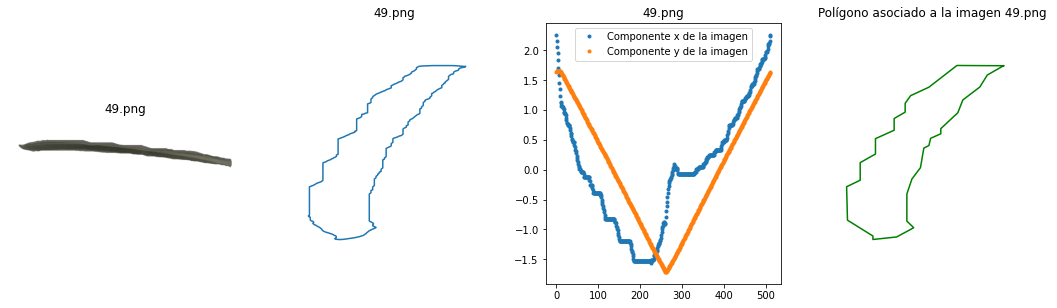

___________________________________________________________________________________________________________________________________________________


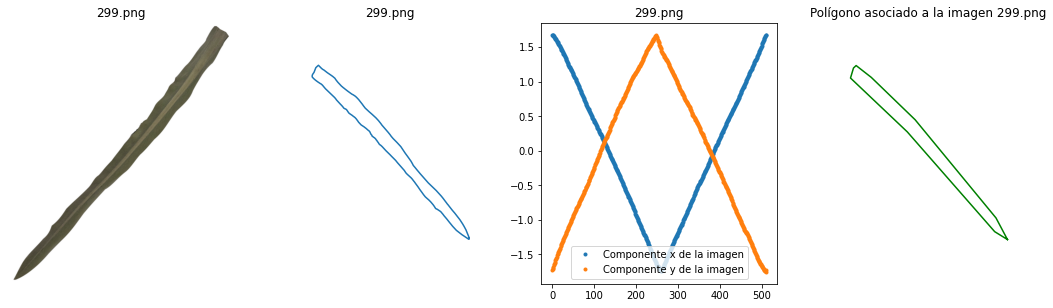

___________________________________________________________________________________________________________________________________________________


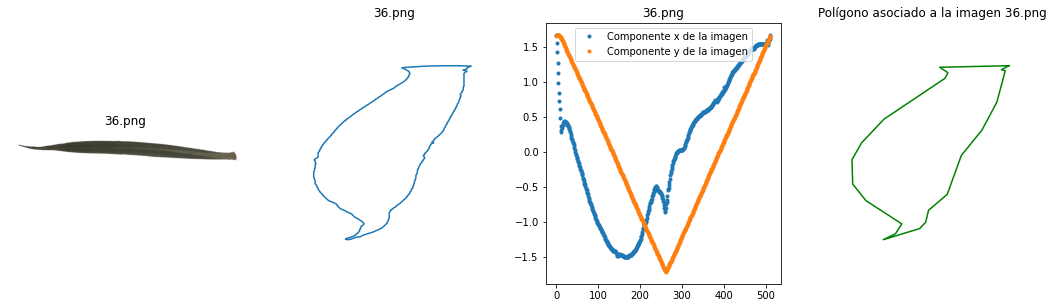

___________________________________________________________________________________________________________________________________________________


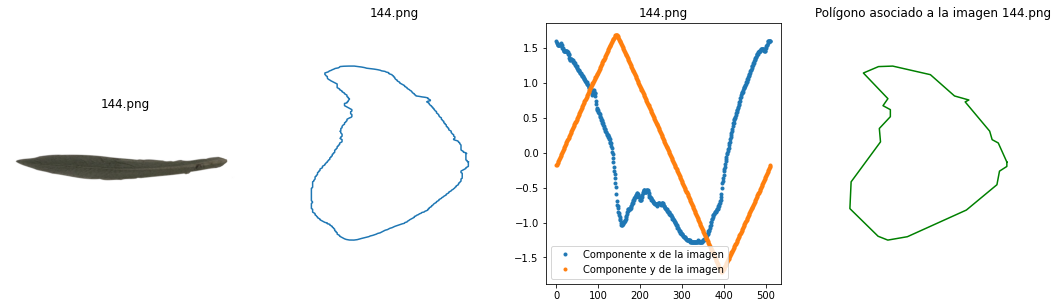

___________________________________________________________________________________________________________________________________________________


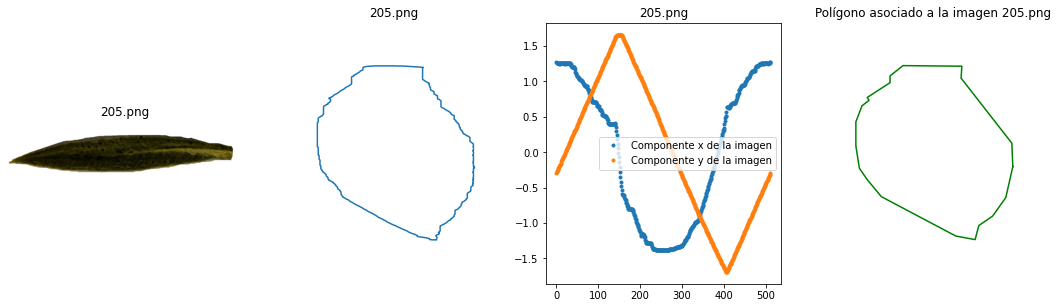

___________________________________________________________________________________________________________________________________________________


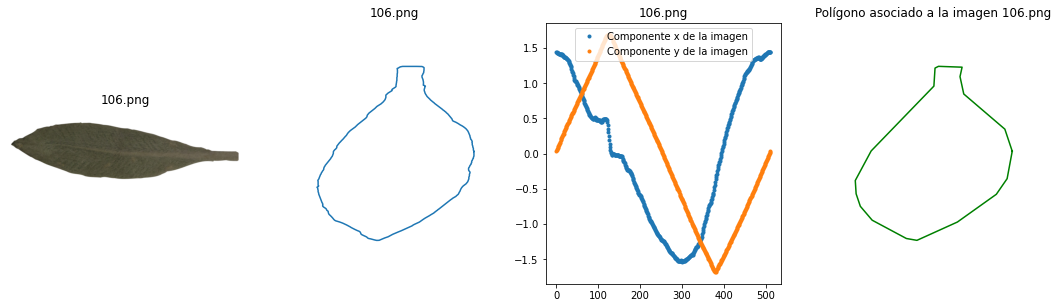

___________________________________________________________________________________________________________________________________________________


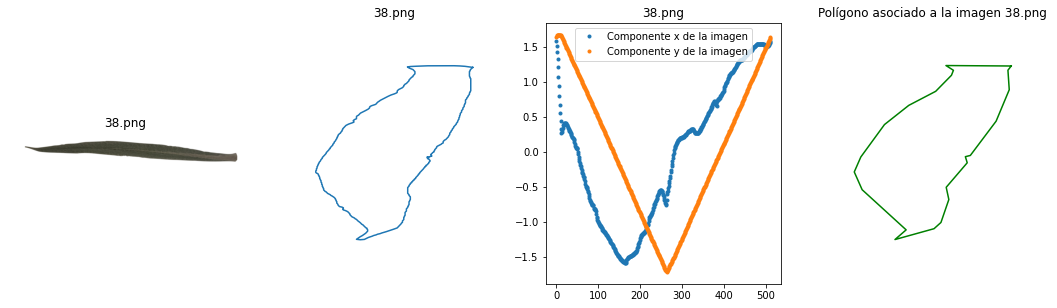

___________________________________________________________________________________________________________________________________________________


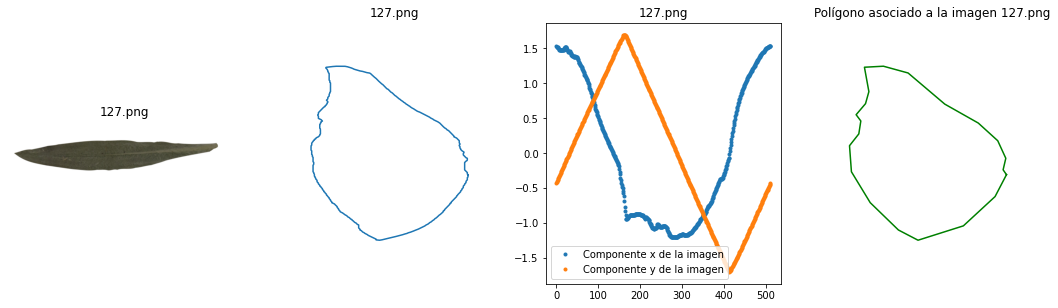

___________________________________________________________________________________________________________________________________________________


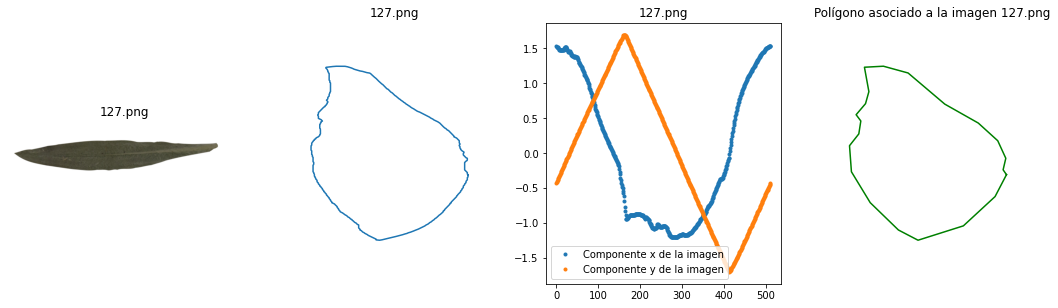

___________________________________________________________________________________________________________________________________________________


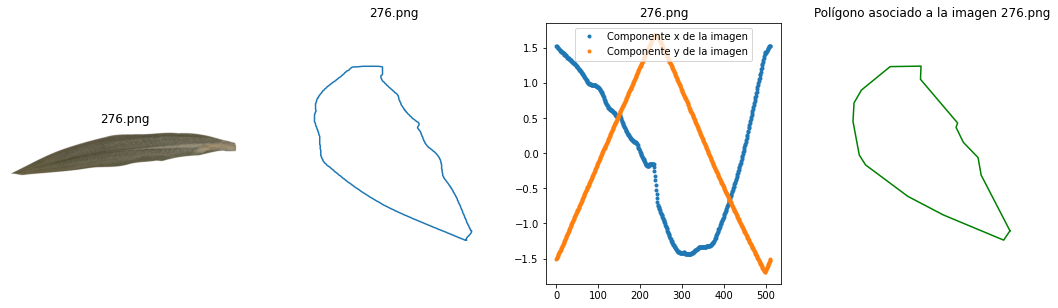

___________________________________________________________________________________________________________________________________________________


In [120]:
for i in range(10):
  a=random.choice(range(len(imgs)))
  Grafica(Imagenes[a],Contorno[a],imgs[a],tolerancia=0.05)
  print("___________________________________________________________________________________________________________________________________________________")

Hallando Características:

In [146]:
Area=[]
Perimetro=[]
Centro=[]
Dist_eje_mayor=[]
Dist_eje_menor=[]
Eccentricidad=[]

for i in imgs:
  area,perim,ecce,ma_x,me_x, cent=props(ruta+i)
  Area.append(area)
  Perimetro.append(perim)
  Eccentricidad.append(ecce)
  Dist_eje_mayor.append(ma_x)
  Dist_eje_menor.append(me_x)
  Centro.append(np.array(cent))


Generando el dataframe de los datos obtenidos de la imágenes

In [150]:
df=pd.DataFrame()
df["Imagen"]=imgs
df["Perímetro"]=Perimetro
df["Area"]=Area
df["Longitud del eje central mayor"]=Dist_eje_mayor
df["Longitud del eje central menor"]=Dist_eje_menor
df["Eccentricidad"]=Eccentricidad
df["Centroide"]=Centro

###Descripción de los datos

In [ ]:
df.describe()

,Perímetro,Area,Longitud del eje central mayor,Longitud del eje central menor,Eccentricidad
count,314.000000,3.140000e+02,314.000000,314.000000,314.000000
mean,7960.054949,7.355120e+05,2098.821945,701.272888,0.915758
std,2804.971544,7.023023e+05,720.253167,374.745033,0.097706
min,2004.208153,6.281000e+04,502.795792,192.188864,0.384353
25%,6121.657467,3.152985e+05,1665.453131,462.655742,0.911776
50%,7818.664610,5.027975e+05,2123.418441,586.561543,0.951418
75%,9879.234505,8.870805e+05,2514.033406,822.696932,0.972398
max,17336.919549,4.431088e+06,3738.525312,2488.644394,0.991488


Diagramas de Caja y de violín para cada característica 

In [ ]:
sns.boxplot("Perímetro",data=df)
plt.show()
sns.violinplot("Perímetro",data=df)
plt.show()

sns.boxplot("Area",data=df, color="red")
plt.show()
sns.violinplot("Area",data=df,color="red")
plt.show()

sns.boxplot("Longitud del eje central mayor",data=df,color="green")
plt.show()
sns.violinplot("Longitud del eje central mayor",data=df,color="green")
plt.show()

sns.boxplot("Longitud del eje central menor",data=df,color="pink")
plt.show()
sns.violinplot("Longitud del eje central menor",data=df, color="pink")
plt.show()

sns.boxplot("Eccentricidad",data=df, color="orange")
plt.show()
sns.violinplot("Eccentricidad",data=df,color="orange")
plt.show()

Transformada discreta Fourier

In [185]:
n_armonics=256
j = cmath.sqrt(-1)
features= np.zeros((len(imgs),n_armonics),dtype=complex)
for i in range(len(imgs)):
  x=Contorno[i,:,0]-Contorno[i,:,1]*j
  dx  = np.diff(x, axis=0)
  norm_x=np.absolute(dx)
  x=np.divide(dx,norm_x)
  armonics=np.fft.fft(x,n=n_armonics)
  features[i]=armonics      #Espacio de características

**Armónicos:**

In [186]:
Armonicos=[]
for i in range(n_armonics):
  Armonicos.append(f"Armónico {i+1}")

Armon=pd.DataFrame()
Armon["Imágenes"]=imgs
for i in range(n_armonics):
  Armon[Armonicos[i]]=features[:,i]

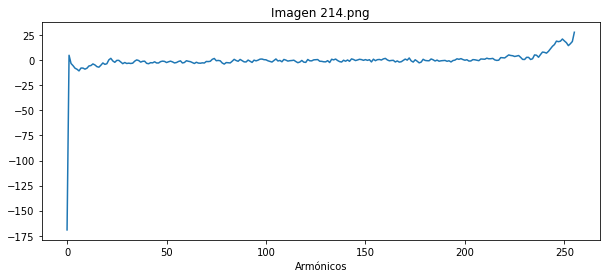

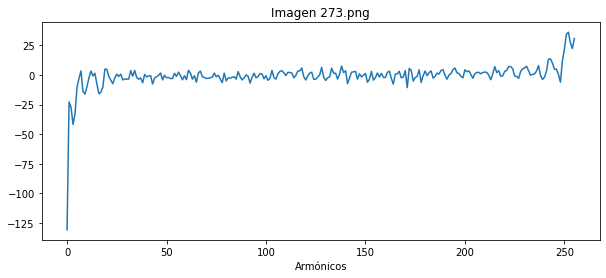

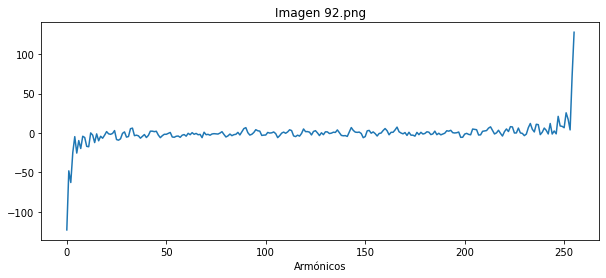

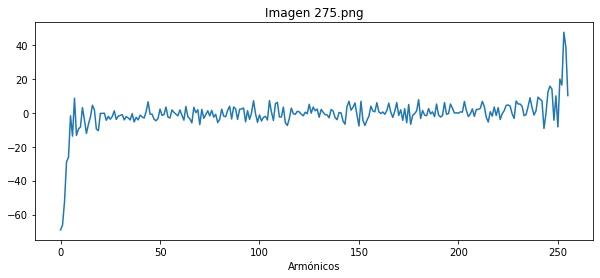

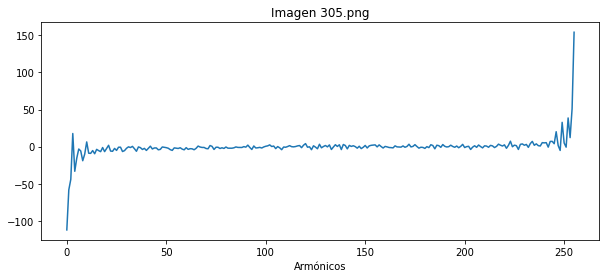

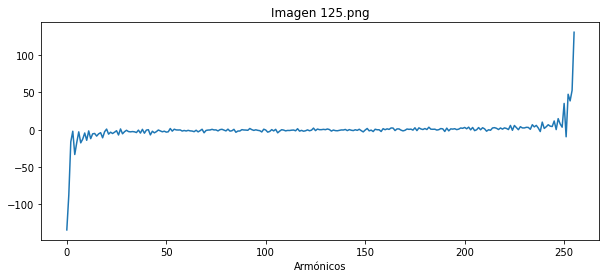

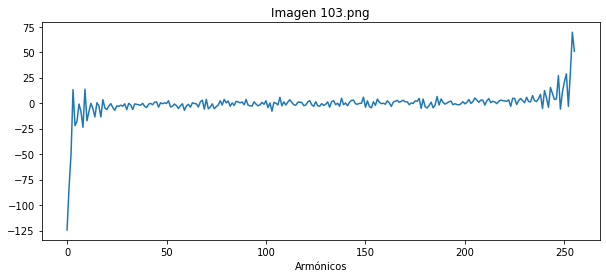

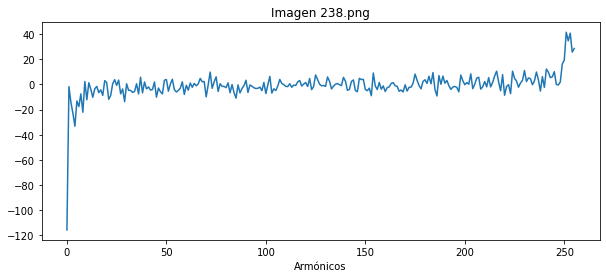

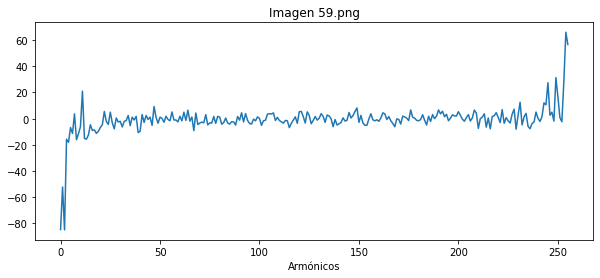

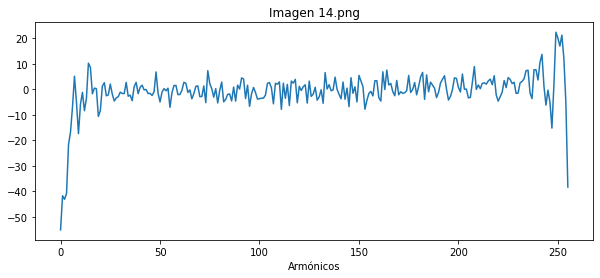

In [215]:
for i in range(10):
  pos=np.random.choice(range(len(imgs)))  
  name=imgs[pos]
  plt.figure(figsize=(10,4))
  plt.xlabel("Armónicos")
  plt.title(f"Imagen {name}")
  plt.plot(features[pos],"-")

**Momentos Hu**: Los momentos de una imagen son un conjunto de caracterizadores de datos en segunda dimensión que usualamente  funcionan para identificar numéricamente una imagen, los momentos de una función bivariada estan definidos por 
$$\mu_{pq}=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}x^py^q f(x,y)dxdy$$


Los momentos que se caracterizan por ser invariantes bajo translaciones y escalación uniforme pero so son afectados por la rotaciones, una clásica solución de este problema es una combinación lineal  de estos momentos, estas combinaciones son llamadas momentos de Hu mostrados a continuación:



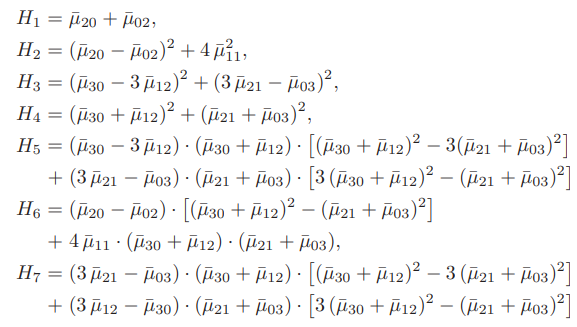

In [ ]:
momentos_Hu=np.zeros((len(imgs),7))
cont=0
for i in imgs:
  hu=Hu_moments(ruta+i)
  momentos_Hu[cont]=np.log(hu)
  cont+=1

In [ ]:
Hu=pd.DataFrame()
Hu["Imágenes"]=imgs
Hu["H1"]=momentos_Hu[:,0]
Hu["H2"]=momentos_Hu[:,1]
Hu["H3"]=momentos_Hu[:,2]
Hu["H4"]=momentos_Hu[:,3]
Hu["H5"]=momentos_Hu[:,4]
Hu["H6"]=momentos_Hu[:,5]
Hu["H7"]=momentos_Hu[:,6]

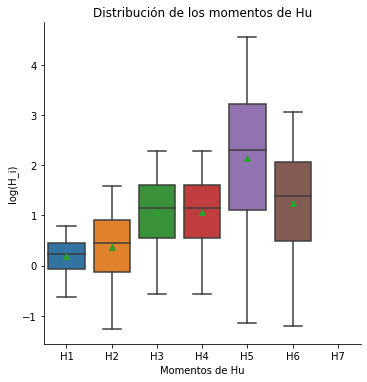

In [177]:
sns.catplot(data=Hu,showmeans=True,kind="box")
plt.ylabel("log(H_i)")
plt.xlabel("Momentos de Hu")
plt.title("Distribución de los momentos de Hu")
plt.show()

#Pruebas y errores


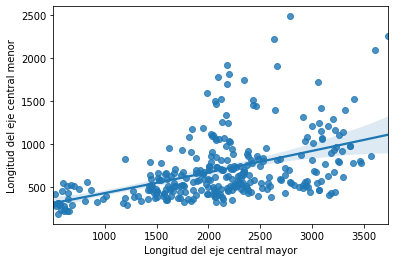

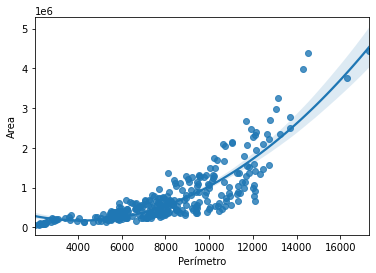

In [ ]:
sns.regression.regplot(x="Longitud del eje central mayor",y="Longitud del eje central menor",data=df,order=2)
plt.show()
sns.regression.regplot(x="Perímetro",y="Area",data=df,order=2)
plt.show()

In [220]:
Prueba=mahotas.features.zernike_moments(Imagenes[20][:,:,0],degree=2,radius=0.8)
print(Prueba)

[0.31830989 0.14350456 0.8578848  0.04852243]
